In [302]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
from matplotlib import colormaps
import matplotlib.colors as color
import calculators as calc
import conversion as conv
import errors as err
import measures as ms
import tables as tab
import df_transformers as trans
from star_calculators import StarCalculator

<h2>Загрузка и первичная очистка данных</h2>

Масса Земли в массах Юпитера

In [303]:
JUP_MASS_EARTH = 316.8

Радиус Земли в радиусах Юпитера

In [304]:
JUP_RAD_EARTH = 11.2

Функции преобразования масс и радиусов в Юпитерах в логарифмы масс и радиусов в Землях

In [305]:
calc_log_e_ms = lambda x: np.log10(x * JUP_MASS_EARTH)
calc_log_e_rd = lambda x: np.log10(x * JUP_RAD_EARTH)

Преобразование масс и радиусов планет из датасета

In [306]:
def get_log_pmass(df):
    return df["mass"].map(calc_log_e_ms).to_list()

def get_log_prad(df):
    return df["radius"].map(calc_log_e_rd).to_list()

Функция отображения данных по осям логарифма радиуса в Землях и логарифма массы в Землях

In [307]:
def show_mass_radius_plot(df, title):
    mass = get_log_pmass(df)
    radius = get_log_prad(df)

    fig, axes = plot.subplots()

    fig.set_figwidth(9)
    fig.set_figheight(6)

    axes.scatter(mass, radius, s=3, alpha=0.4)

    axes.set_title(title)

    axes.set_xlabel("log(Масса, масс Земли)")
    axes.set_ylabel("log(Радиус, рад. Земли)")

    axes.set_xlim(-2, 5)
    axes.set_ylim(-1, 2)

    plot.show()

def show_mass_radius_hist(df, title):
    def intr_count(df):
        cou = int(np.log2(len(df)))

        return cou

    def vals_by_intr(val, cou):
        min_val = min(val)
        max_val = max(val)

        intr = (max_val - min_val) / cou

        intrs = {}
        for i in np.arange(min_val, max_val, intr):
            intrs[i + intr] = 0

        for m in val:
            for i in reversed(intrs.keys()):
                if m > i:
                    intrs[i] += 1
                    break

        intrs_m = dict(
            map(
                lambda kw: (kw[0] + intr / 2, kw[1]), 
                intrs.items()
            )
        )

        return intrs_m, intr
    
    def get_max_freq(mass_intrs, radius_intrs):
        max_mintr_f = max(mass_intrs.values())
        max_rintr_f = max(radius_intrs.values())

        max_f = max(max_mintr_f, max_rintr_f)

        return max_f

    mass = get_log_pmass(df)
    radius = get_log_prad(df)

    intr_c = intr_count(df)

    mass_intrs, mintr = vals_by_intr(mass, intr_c)
    radius_intrs, rintr = vals_by_intr(radius, intr_c)

    fig, axes = plot.subplots(ncols=2)

    fig.set_figwidth(18)
    fig.set_figheight(6)

    fig.suptitle(title)

    axes[0].bar(mass_intrs.keys(), mass_intrs.values(), width=0.9 * mintr, color="#89b949")
    axes[1].bar(radius_intrs.keys(), radius_intrs.values(), width=0.9 * rintr, color="#6969b9")

    max_f = get_max_freq(mass_intrs, radius_intrs)
    for a in axes:
        a.set_ylim(0, max_f * 1.1)

    axes[0].set_title("по массе")
    axes[0].set_xlim(-2, 5)
    axes[0].set_xlabel("log(Масса, масс Земли)")
    
    axes[1].set_title("по радиусу")
    axes[1].set_xlim(-1, 2)
    axes[1].set_xlabel("log(Радиус, рад. Земли)")

Загрузка данных и выбор колонок

In [308]:
cols = [
    "name", 
    "mass", 
    "mass_error_min", 
    "mass_error_max",
    "radius",
    "radius_error_min",
    "radius_error_max",
    "orbital_period",
    "orbital_period_error_min",
    "orbital_period_error_max",
    "semi_major_axis",
    "semi_major_axis_error_min",
    "semi_major_axis_error_max",
    "eccentricity",
    "eccentricity_error_min",
    "eccentricity_error_max",
    "temp_calculated",
    "temp_calculated_error_min",
    "temp_calculated_error_max",
    "temp_measured",
    "star_name",
    "mag_v",
    "star_distance",
    "star_distance_error_min",
    "star_distance_error_max",
    "star_sp_type",
    "star_metallicity",
    "star_metallicity_error_min",
    "star_metallicity_error_max",
    "star_mass",
    "star_mass_error_min",
    "star_mass_error_max",
    "star_radius",
    "star_radius_error_min",
    "star_radius_error_max",
    "star_teff",
    "star_teff_error_min",
    "star_teff_error_max",
]
exo_df = pd.read_csv("exo_data.csv")[cols]
sol_df = pd.read_csv("sol.csv")[cols]
p_df = pd.concat([exo_df, sol_df])


Выбор объектов, которые являются компаньонами звезд

In [309]:
p_only_comp = p_df.query("star_name.notna() and (orbital_period.notna() or semi_major_axis.notna())")

Выбор объектов, для которых измерены и масса и радиус

In [310]:
p_mass_rad = p_only_comp.query("mass.notna() and radius.notna()")

Гистограммы и распределение выбранных объектов по массе и радиусу

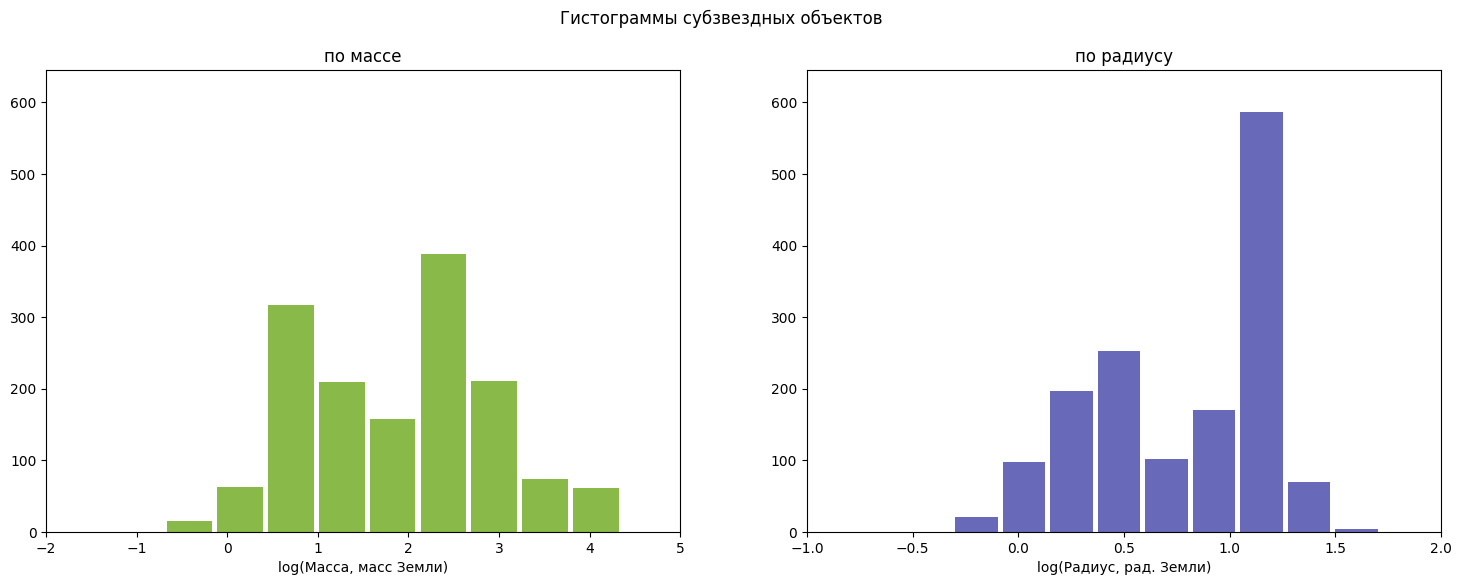

In [311]:
show_mass_radius_hist(p_mass_rad, "Гистограммы субзвездных объектов")

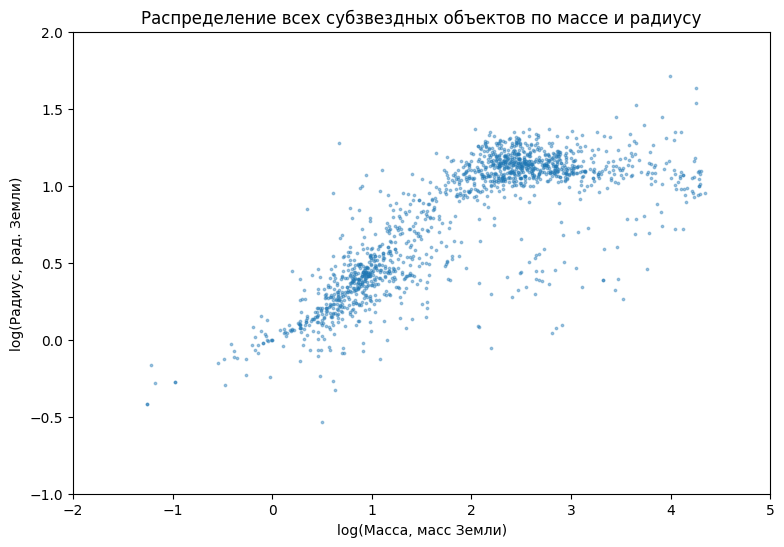

In [312]:
show_mass_radius_plot(p_mass_rad, "Распределение всех субзвездных объектов по массе и радиусу")

Выбор объектов, с точно измеренными массой и радиусом

Выбираются объекты, относительная погрешность которых не превышает MAX_REL_ERR

In [313]:
MAX_REL_ERR = 0.5

precise_q = "(mass_error_min + mass_error_max) / 2 < mass * {rel_err} and (radius_error_min + radius_error_max) / 2 < radius * {rel_err}".format(rel_err=MAX_REL_ERR)
p_precise = p_mass_rad.query(precise_q)

Гистограммы и распределение выбранных объектов по массе и радиусу

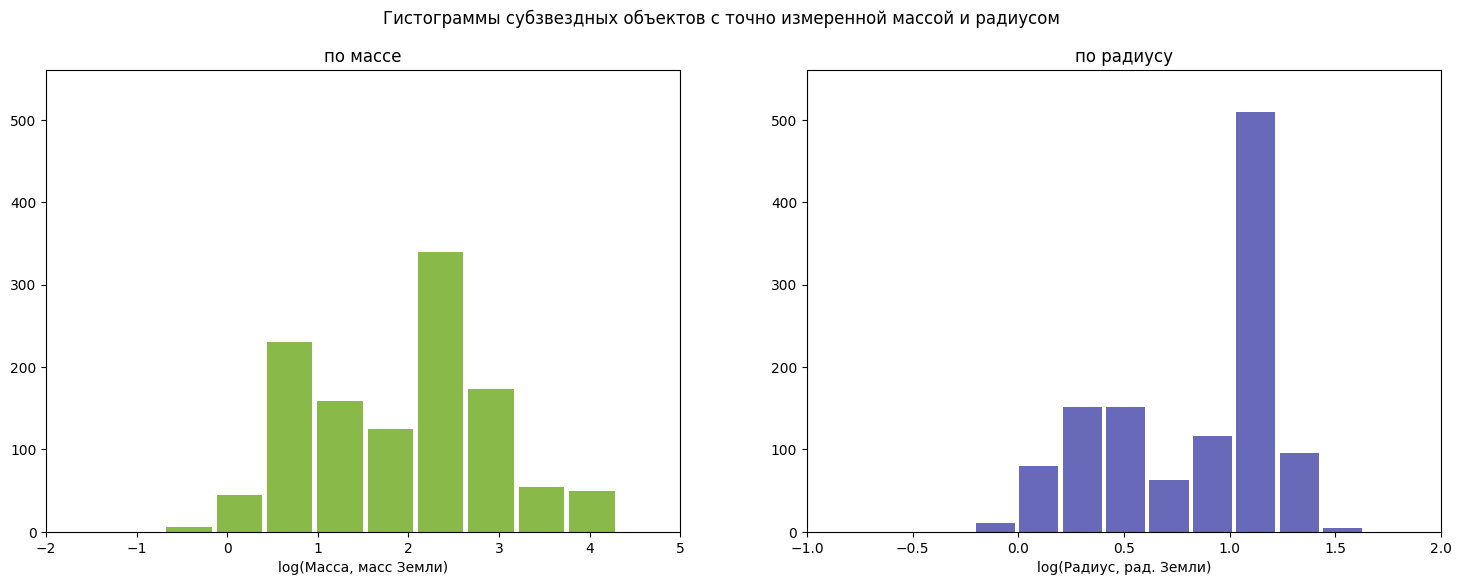

In [314]:
show_mass_radius_hist(p_precise, "Гистограммы субзвездных объектов с точно измеренной массой и радиусом")

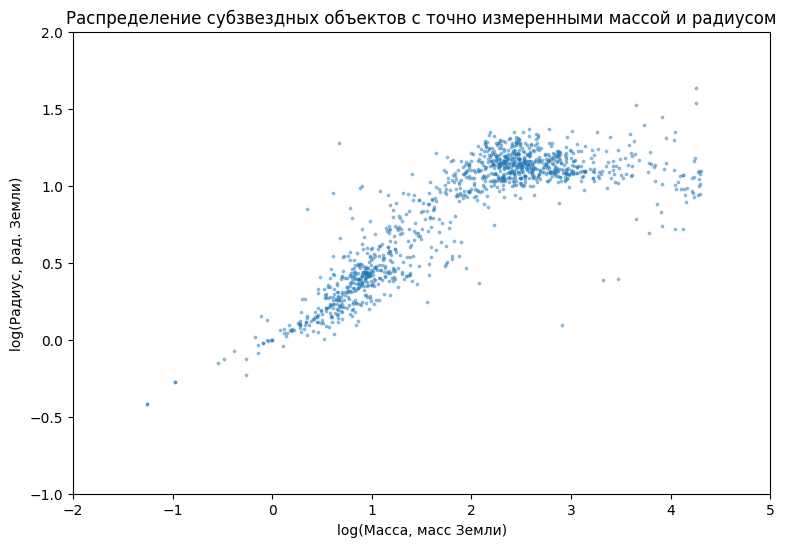

In [315]:
show_mass_radius_plot(p_precise, "Распределение субзвездных объектов с точно измеренными массой и радиусом")

Выбор объектов планетарной массы

Объектами планетарной массы будем считать те объекты, масса которых не превышает MAX_PL_MASS_JUP масс ЮПИТЕРА

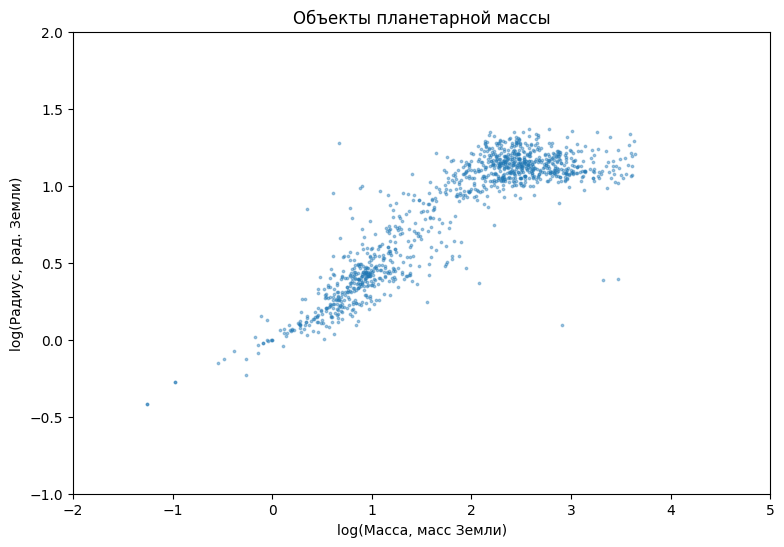

In [316]:
MAX_PL_MASS_JUP = 14

only_planets_q = "mass < {mass}".format(mass=MAX_PL_MASS_JUP)
p_only_planets = p_precise.query(only_planets_q)

show_mass_radius_plot(p_only_planets, "Объекты планетарной массы")

Сохраняем предварительно отфильтрованные данные в файл

In [317]:
p_only_planets = p_only_planets.set_index(pd.RangeIndex(start=0, stop=len(p_only_planets), step=1))
p_only_planets.to_csv("exo_filtered.csv")

In [318]:
SP_CLASS_TABLE = {
    "B": (10000.0, 30000.0),
    "A": (7400.0, 10000.0),
    "F": (6000.0, 7400.0),
    "G": (5000.0, 6000.0),
    "K": (3800.0, 5000.0),
    "M": (2500.0, 3800.0),
    "L": (1300.0, 2500.0),
    "T": (600.0, 1300.0)
}

<h2>Расчет недостающих данных</h2>

In [319]:
converter = conv.MeasureConverter()
rou = err.Round()

Генерация погрешности для данных, где они не указаны

In [320]:
err_gen_by_order = err.ErrorGeneratorByOrder()
err_gen_star_teff = err.ErrorGeneratorStarTeff()

period_err_gen = trans.DFErrorGen(converter, err_gen_by_order, "orbital_period", ms.OrbitalPeriod)
smass_err_gen = trans.DFErrorGen(converter, err_gen_by_order, "star_mass", ms.SemiMajorAxis)
steff_err_gen = trans.DFErrorGen(converter, err_gen_star_teff, "star_teff", ms.StarTeff)
smaxis_err_gen = trans.DFErrorGen(converter, err_gen_by_order, "semi_major_axis", ms.SemiMajorAxis)

calc_df = period_err_gen.gen(p_only_planets)
calc_df = smass_err_gen.gen(calc_df)
calc_df = steff_err_gen.gen(calc_df)
calc_df = smaxis_err_gen.gen(calc_df)

Определение эффективной температуры фотосферы звезды по спектральному классу

In [321]:
steff_table = tab.SpClassTeffTable(SP_CLASS_TABLE)

steff_calc_df = trans.DFStarTeffBySpClassCalc(converter, steff_table)

calc_df = steff_calc_df.set_vals(calc_df)

{'B-1': TableValue(val=20000.0, err=20000.0), 'B0.0': TableValue(val=29000.0, err=1000.0), 'B0.5': TableValue(val=28000.0, err=1000.0), 'B1.0': TableValue(val=27000.0, err=1000.0), 'B1.5': TableValue(val=26000.0, err=1000.0), 'B2.0': TableValue(val=25000.0, err=1000.0), 'B2.5': TableValue(val=24000.0, err=1000.0), 'B3.0': TableValue(val=23000.0, err=1000.0), 'B3.5': TableValue(val=22000.0, err=1000.0), 'B4.0': TableValue(val=21000.0, err=1000.0), 'B4.5': TableValue(val=20000.0, err=1000.0), 'B5.0': TableValue(val=19000.0, err=1000.0), 'B5.5': TableValue(val=18000.0, err=1000.0), 'B6.0': TableValue(val=17000.0, err=1000.0), 'B6.5': TableValue(val=16000.0, err=1000.0), 'B7.0': TableValue(val=15000.0, err=1000.0), 'B7.5': TableValue(val=14000.0, err=1000.0), 'B8.0': TableValue(val=13000.0, err=1000.0), 'B8.5': TableValue(val=12000.0, err=1000.0), 'B9.0': TableValue(val=11000.0, err=1000.0), 'B9.5': TableValue(val=10000.0, err=1000.0), 'A-1': TableValue(val=8700.0, err=2600.0), 'A0.0': Tab

Расчет большой полуоси орбиты планеты

In [322]:
smaxis_calc = calc.SemiMajorAxisCalc()

sm_axis_calc_df = trans.DFSemiMajorAxisCalc(converter, smaxis_calc, rou)

calc_df = sm_axis_calc_df.calc(calc_df)

Расчет средней эффективной температуры планеты

In [323]:
pteff_mean_calc = calc.PlanetTeffCalc()

pteff_mean_calc_df = trans.DFPlanetTeffMeanCalc(converter, pteff_mean_calc, rou)

calc_df = pteff_mean_calc_df.calc(calc_df)

calc_df.to_csv("exo_with_teff.csv")

In [324]:
BG_COLOR = "0.15"
PLOT_BG_COLOR = "0.18"
T_TITLE_COLOR = "white"
T_COLOR = "0.8"

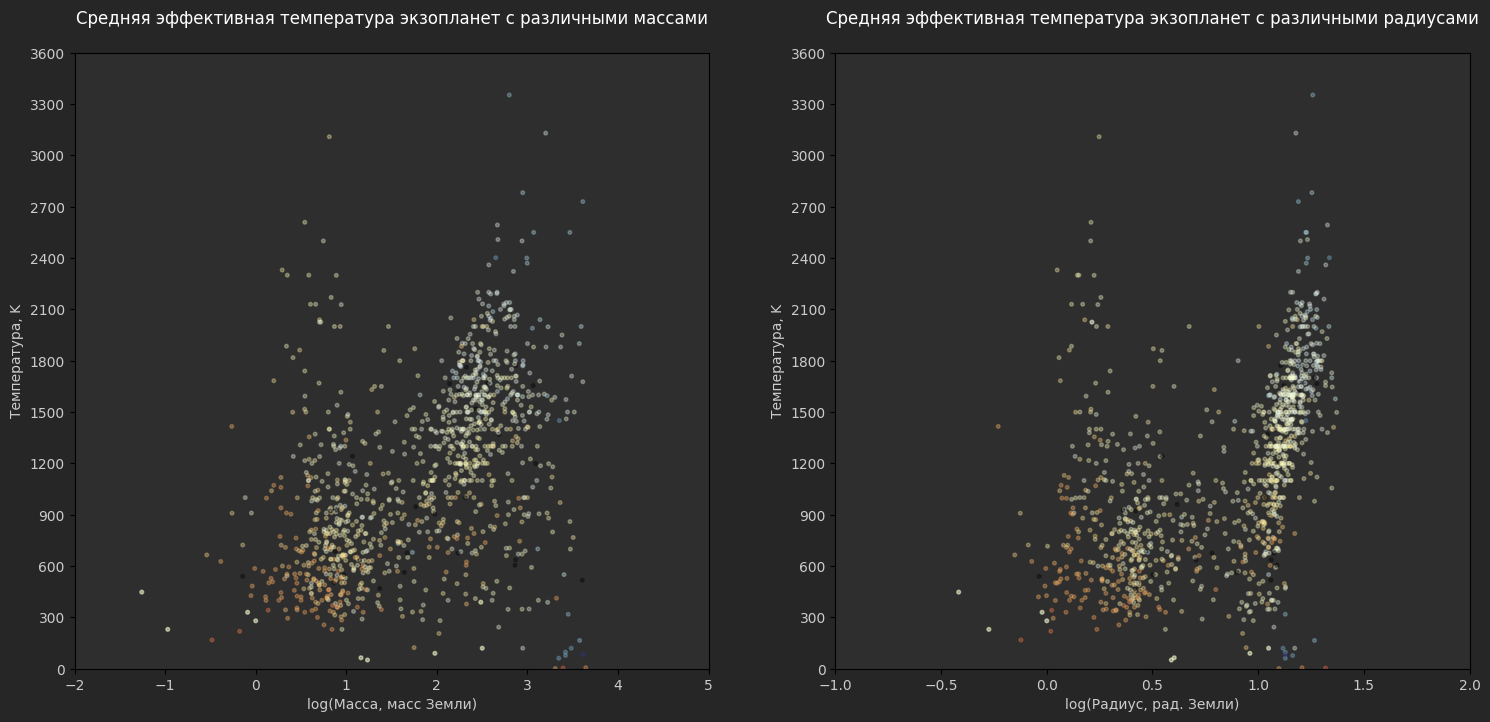

In [325]:
mean_teff = calc_df.get("temp_calculated").tolist()
star_teff = calc_df.get("star_teff").tolist()
val = get_log_pmass(calc_df)
radius = get_log_prad(calc_df)

fig, axes = plot.subplots(facecolor=BG_COLOR, ncols=2)

fig.set_figwidth(18)
fig.set_figheight(8)

colormap = colormaps.get_cmap("RdYlBu")
norm = color.Normalize(0, 11000)

axes[0].scatter(val, mean_teff, s=7, alpha=0.33, color=colormap(norm(star_teff)))
axes[1].scatter(radius, mean_teff, s=7, alpha=0.33, color=colormap(norm(star_teff)))

for a in axes:
    a.set_facecolor(PLOT_BG_COLOR)

    a.set_ylabel("Температура, K", color=T_COLOR)
    a.set_ylim(0, 3000)
    a.set_yticks(np.arange(0, 3800, 300))

    a.tick_params(labelcolor=T_COLOR)

axes[0].set_title("Cредняя эффективная температура экзопланет с различными массами\n", color=T_TITLE_COLOR)
axes[0].set_xlabel("log(Масса, масс Земли)", color=T_COLOR)
axes[0].set_xlim(-2, 5)

axes[1].set_title("Cредняя эффективная температура экзопланет с различными радиусами\n", color=T_TITLE_COLOR)
axes[1].set_xlabel("log(Радиус, рад. Земли)", color=T_COLOR)
axes[1].set_xlim(-1, 2)

plot.show()

In [326]:
smass_calc = calc.StarMassCalc()

smass_calc_df = trans.DFStarMassCalculator(converter, smass_calc, rou, StarCalculator)

smass_df = smass_calc_df.calc(calc_df)

In [327]:
smass_df.to_csv("exo_with_star_mass.csv")

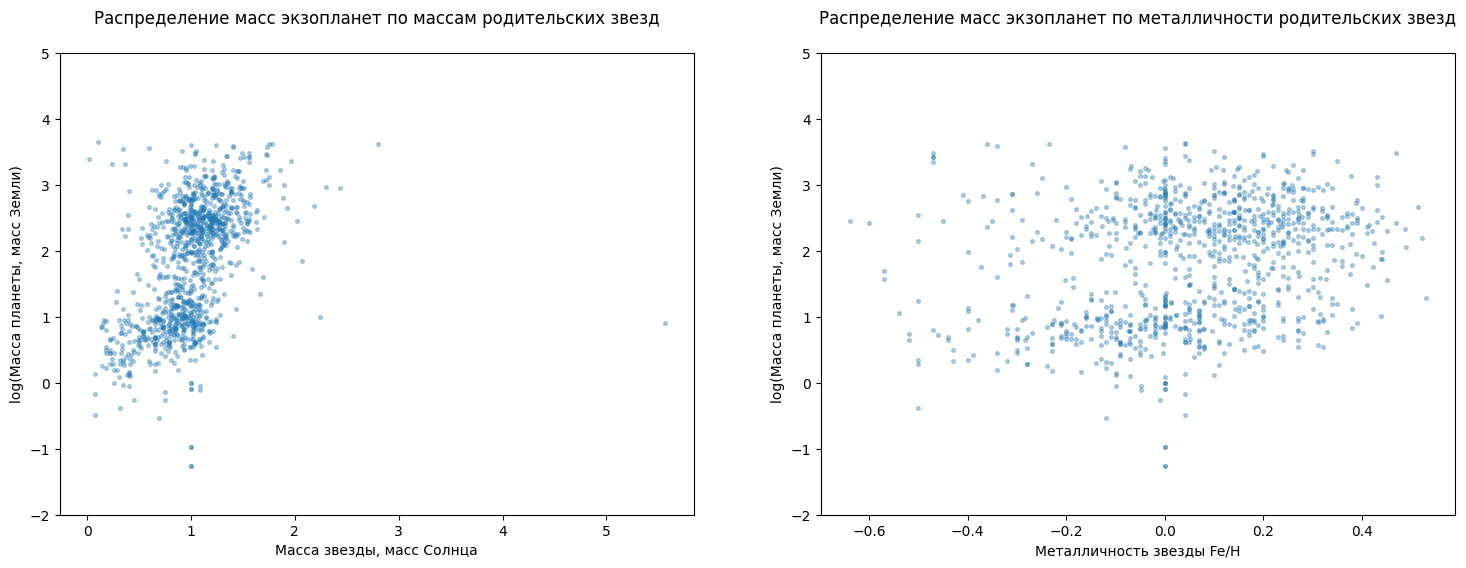

In [328]:
s_mass = smass_df.get("star_mass").tolist()
s_feh = smass_df.get("star_metallicity").tolist()
val = get_log_pmass(smass_df)

fig, axes = plot.subplots(ncols=2)

fig.set_figwidth(18)
fig.set_figheight(6)

axes[0].scatter(s_mass, val, s=7, alpha=0.33)
axes[1].scatter(s_feh, val, s=7, alpha=0.33)

for a in axes:
    a.set_ylabel("log(Масса планеты, масс Земли)")
    a.set_ylim(-2, 5)

axes[0].set_title("Распределение масс экзопланет по массам родительских звезд\n")
axes[0].set_xlabel("Масса звезды, масс Солнца")

axes[1].set_title("Распределение масс экзопланет по металличности родительских звезд\n")
axes[1].set_xlabel("Металличность звезды Fe/H")

plot.show()